# Evaluating Point-cloud Object Detections with FiftyOne

Point-clouds are an efficient way of representing three dimensional spatial data. They can be generated via either laser scanning techniques, such as [Lidar](https://en.wikipedia.org/wiki/Lidar), or photogrammetry, and are used in a variety of computer vision arenas, including autonomous vehicles, robots, and augmented and virtual reality. 

This walkthrough demonstrates how to use FiftyOne to work with three dimensional point-cloud data. 

In the walkthrough, we will cover the following topics:

* Loading a dataset with point-cloud data into FiftyOne
* Visualizing three dimensional data with the FiftyOne $3d$ visualizer
* Generating predictions from point-cloud data.
* Evaluating three-dimensional object detections.

#### So, what's the takeaway?

While the preprocessing and post-processing of point-cloud data can be quite distinct from the analogous image tasks, the same (or very similar) evaluation and visualization techniques apply.

## Setup

If you haven’t already, install FiftyOne:

In [1]:
# !pip install fiftyone

In this tutorial, we’ll use a Complex-YOLO model in the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html). This model is implemented in PyTorch, and to use it, you’ll need to have `torch` and `torchvision` installed.

In [2]:
# !pip install torch torchvision

Now we import all of the packages we will be using:

In [3]:
import math
import numpy as np
import cv2
import torch
import open3d as o3d
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import eta.core.utils as etau
import fiftyone.utils.kitti as fouk
import fiftyone.utils.utils_3d as fou3d
import fiftyone.utils.complex_yolo as foucy

The data we will be working with is the [KITTI Multiview dataset](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d), which is conveniently available for download via the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html).  

**NOTE**: In order to robustly capture a three dimensional scene, an individual point-cloud can have hundreds of thousands, millions, or even tens of millions of points. As a result, three dimensional dataset can be quite large. The KITTI Multiview dataset is no exception. It takes up $53.34$GB. All but one section of this tutorial (projecting $3d$ detections into $2d$) work with the [Quickstart Groups dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#quickstart-groups), which only requires $516.3$MB of storage. If you want to use the quickstart data instead, switch which of the two lines below is commented out.

Here, we are only going to use the training split of the dataset.

In [4]:
dataset = foz.load_zoo_dataset(
    "kitti-multiview",
    split="train",
    dataset_name="pcd_tutorial"
)
                              
# dataset = foz.load_zoo_dataset(
#     "quickstart-groups",
#     split="train",
#     dataset_name="pcd_tutorial"
# )

Parsing dataset metadata
Found 22443 samples
Dataset info written to '/Users/jacobmarks/fiftyone/kitti-multiview/info.json'
Loading 'kitti-multiview' split 'train'
Importing samples...
 100% |█████████████| 22443/22443 [1.3s elapsed, 0s remaining, 17.1K samples/s]         
Migrating dataset 'pcd_tutorial' to v0.18.0
Import complete
Dataset 'pcd_tutorial' created


## Understanding the dataset

In FiftyOne, the KITTI Multiview dataset is a [Grouped Dataset](https://voxel51.com/docs/fiftyone/user_guide/groups.html):

In [5]:
print(dataset.media_type)

group


Each group contains three media files corresponding to the same scene - a "left" image, a "right" image, and a point cloud "pcd" file:

In [6]:
print(dataset.group_slices)

['left', 'right', 'pcd']


The default group slice for the group is "left", as we can see by inspecting the dataset:

In [7]:
dataset

Name:        pcd_tutorial
Media type:  group
Group slice: left
Num groups:  7481
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    group:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

This is the group slice whose media will appear in the sample grid when we launch the FiftyOne App:

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



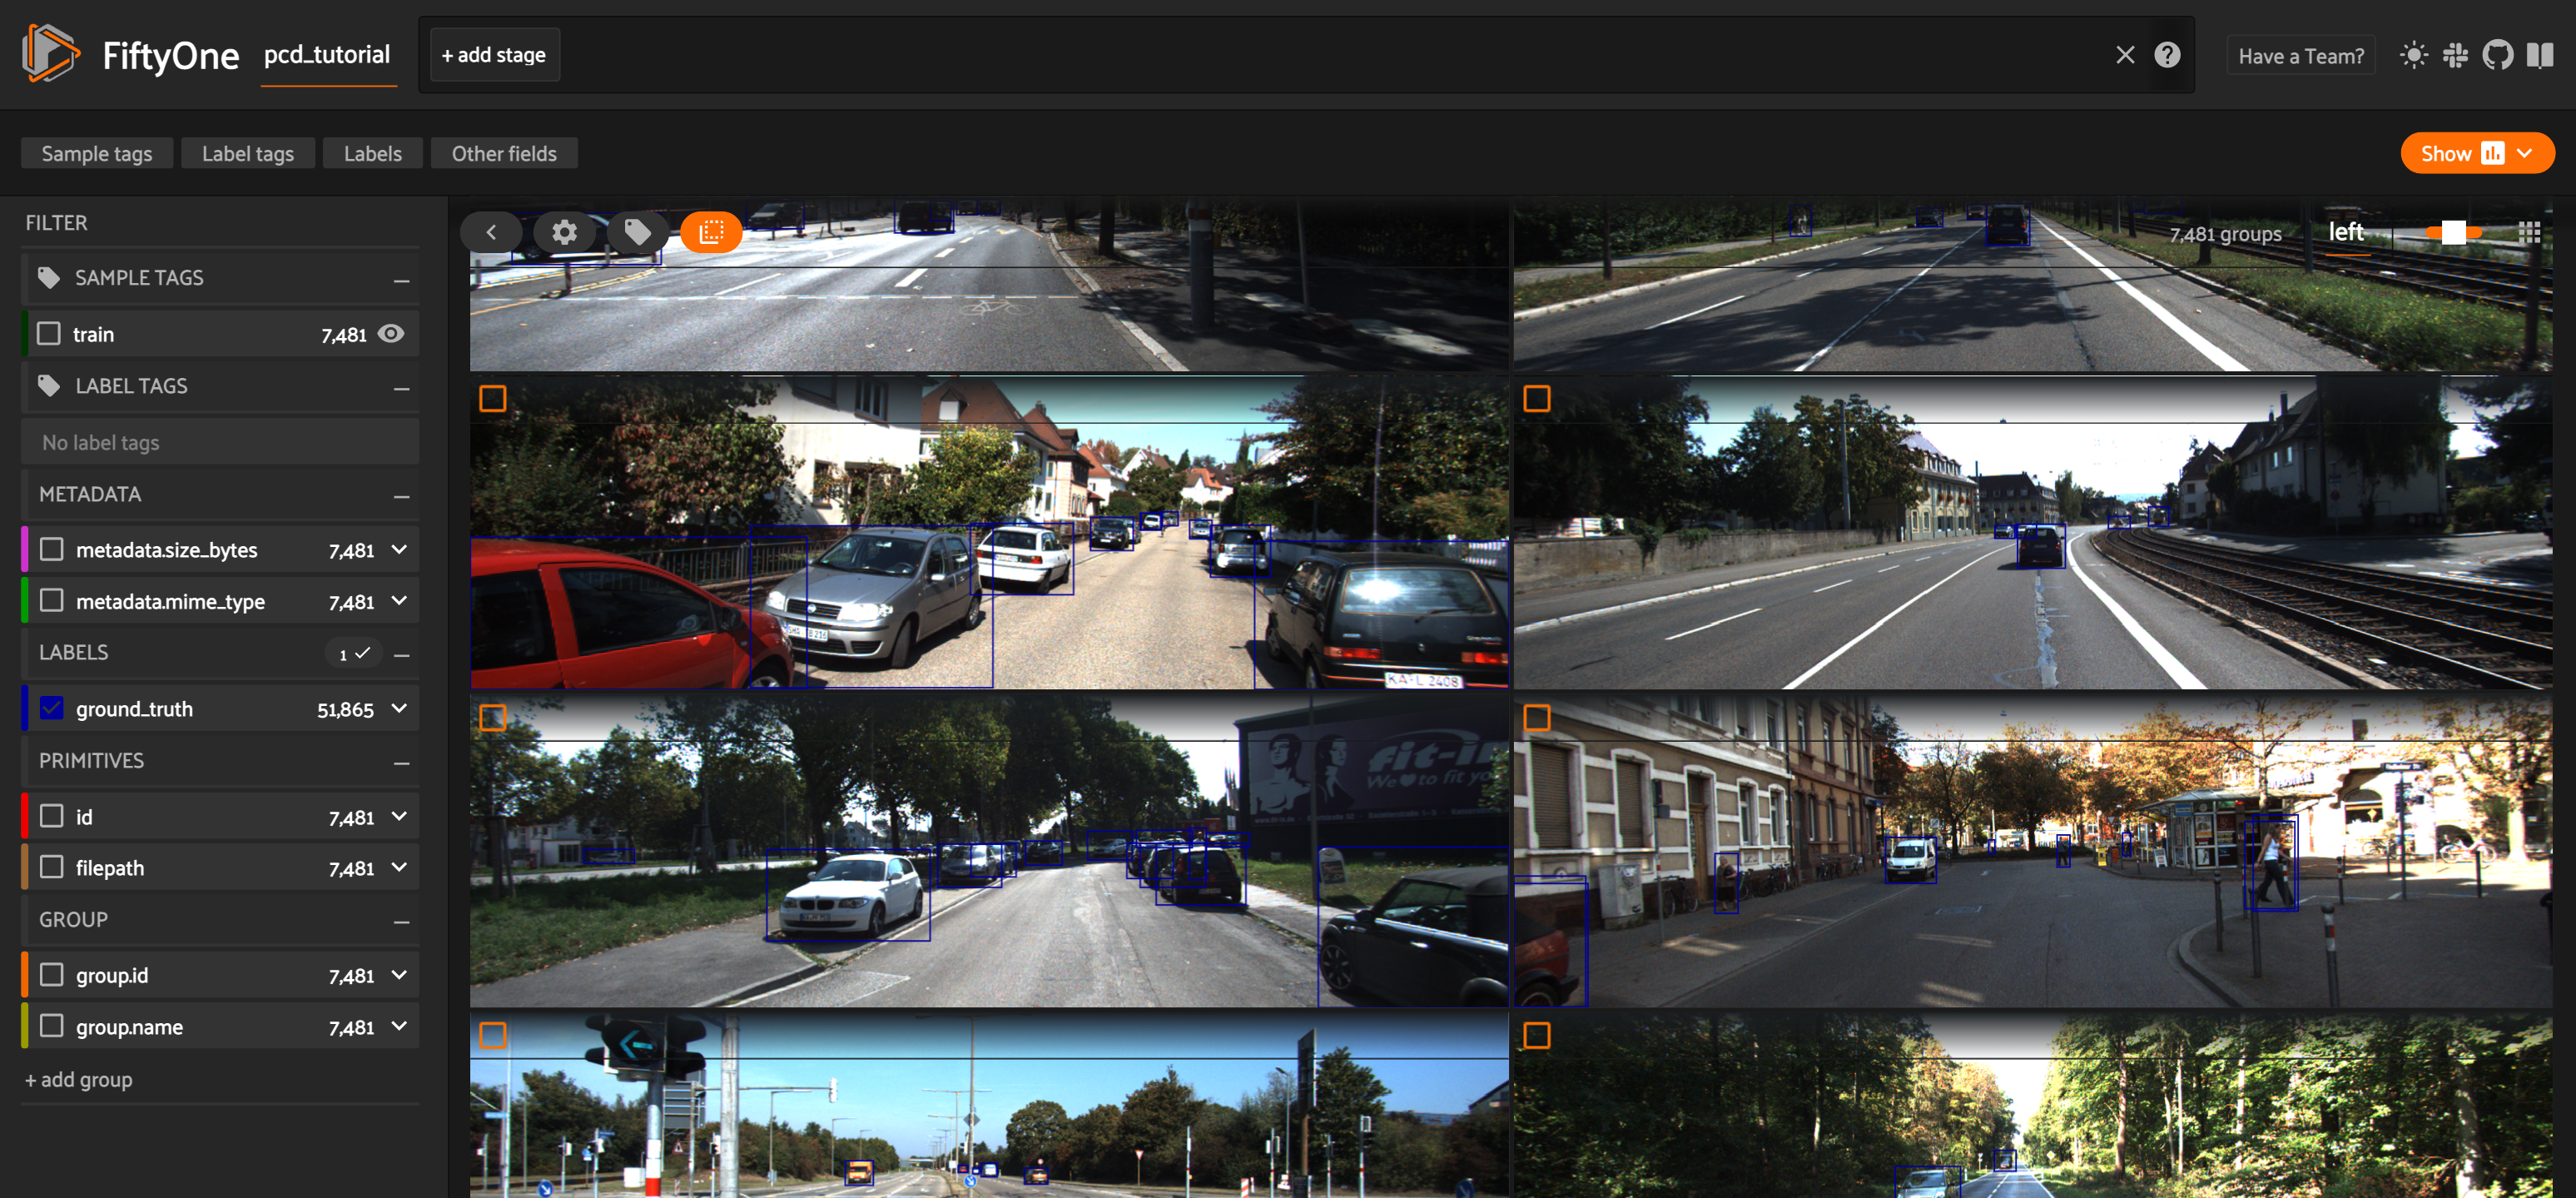

In [8]:
dataset.group_slice = "left"
session = fo.launch_app(dataset)

When we click on one of the images in the grid, it pulls up all three samples in the associated group. On the right side of FiftyOne App, we can see the point cloud data visualized in FiftyOne's $3d$ visualizer. We'll inspect these three dimensional plots interactively later on in the tutorial.

**Note**: When dealing with grouped datasets in FiftyOne, it is always important to make sure that the operations we are performing are being performed on the desired group slice. Thus, if you want to use a particular group slice, it is best practice to set the group slice immediately prior to your desired operations.

### Point clouds

In [the original dataset](https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d), point-clouds, which were generated using [Velodyne LiDAR](https://velodynelidar.com/wp-content/uploads/2019/12/63-9243-Rev-E-VLP-16-User-Manual.pdf), are stored in Velodyne `.bin` files. For convenience and interoperability with most three dimensional geometry and computer vision libraries, point-clouds in FiftyOne's KITTI Multiview dataset are stored in `.pcd` files, in the [PCD file format](https://pointclouds.org/documentation/tutorials/pcd_file_format.html). 

FiftyOne's $3d$ visualizer currently supports only `.pcd` files and [PolyLines](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#polylines-and-polygons) objects. If your point-clouds are stored in a different format, you will need to convert it first. Many solutions exist for performing these conversions. For instance, to convert from `.ply`, you can read in a file using open3d's `open3d.io.read_point_cloud()` method, and then write out the resulting object to file with the `open3d.io.write_point_cloud()` method.

**Note**: It is possible to create point-cloud only datasets in FiftyOne. All FiftyOne SDK functionality that applies to the point-clouds in grouped datasets will apply equally to point-clouds in point-cloud only datasets. However, when you launch the FiftyOne App, you will see that the sample grid does not populate!

We can inspect the point-clouds more closely using the [open3d geometry](http://www.open3d.org/docs/release/python_api/open3d.geometry.html) library.

To do this, we need to change the active group slice to the "pcd" group slice:

In [9]:
dataset.group_slice = "pcd"

Then we can select one of the samples:

In [10]:
pcd_sample = dataset.first()

Now we can verify that this sample is a point-cloud:

In [11]:
pcd_sample.media_type

'point-cloud'

**Note**: If we wanted to get the point-cloud sample associated with a given "left" or "right" sample, we could do so by getting the sample's group id with `group_id = sample.group.id`, using the `get_group()` method, `group = dataset.get_group(group_id)`, and then getting the id of the `pcd` element: `pcd_id = group["pcd"]`.

Now we can load the `.pcd` file into open3d:

In [12]:
pcd_filepath = pcd_sample["filepath"]
point_cloud = o3d.io.read_point_cloud(pcd_filepath)
print(point_cloud)

PointCloud with 115384 points.


We can also get aggregate info about the point cloud by inspecting the points in the point-cloud. For instance, we can find the minimum and maximum bounds:

In [13]:
pcd_points = np.array(point_cloud.points) ## has shape (Npoints, 3) where 2nd dim is (x, y, z) coords
min_xyz = np.amin(pcd_points, axis = 0)
max_xyz = np.amax(pcd_points, axis = 0)
print("min_xyz = ", min_xyz)
print("max_xyz = ", max_xyz)

min_xyz =  [-71.03600311 -21.10499954  -5.15999985]
max_xyz =  [73.03900146 53.79700089  2.67199993]


### $3d$ detections

In this dataset, samples have detection objects in the ground truth field:

In [14]:
pcd_sample.ground_truth

<Detections: {
    'detections': [
        <Detection: {
            'id': '636c4a0ae570df8a169571d6',
            'attributes': {},
            'tags': [],
            'label': 'Pedestrian',
            'bounding_box': [],
            'mask': None,
            'confidence': None,
            'index': None,
            'dimensions': [1.89, 0.48, 1.2],
            'location': [1.84, 1.47, 8.41],
            'rotation': [0, 0.01, 0],
        }>,
    ],
}>

Most registered detections on the point-cloud sample in a group is accompanied by detections on the left image and on the right image, and vice versa. Let's see an example of this by getting the left and right images corresponding to this point-cloud sample:

In [15]:
dataset.group_slice = "pcd"
group = dataset.get_group(pcd_sample.group.id)
print(group)

{'left': <Sample: {
    'id': '636c4a34e570df8a16984680',
    'media_type': 'image',
    'filepath': '/Users/jacobmarks/fiftyone/kitti-multiview/train/left/000000.png',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': 893783,
        'mime_type': 'image/png',
        'width': 1224,
        'height': 370,
        'num_channels': 3,
    }>,
    'group': <Group: {'id': '636c4a0ae570df8a169571d1', 'name': 'left'}>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '636c4a0ae570df8a169571d5',
                'attributes': {},
                'tags': [],
                'label': 'Pedestrian',
                'bounding_box': [
                    0.5820261437908496,
                    0.3864864864864865,
                    0.08033496732026148,
                    0.4457297297297298,
                ],
                'mask': None,
                'confidence': None,
                'index': None,
        

Here we can see that this scene contains one identified "Pedestrian". In the left and right images, the position and shape of the box bounding the detected object is represented with a `bounding_box`. which is stored in `[<top-left-x>, <top-left-y>, <width>, <height>]` format, with units expressed relative to the image dimensions.

Detections on the point-cloud sample, on the other hand, has `dimensions`, `location`, and `rotation` properties. 

* **Dimensions**: encodes object dimensions $[height, width, length]$ in object coordinates
* **Location**: encodes the object center location [x, y, z] in point-cloud coordinates
* **Rotation**: encodes the object rotation around [x, y, z] camera axes, in $[-\pi, \pi)$

An important detail is that the coordinates of the images are *not* the same as the $(x, y)$ coordinates of the point clouds. To convert between these coordinate systems, as we will do later on, we need information about the orientations of the lidar sensor and cameras used. For the KITTI Multiview dataset, this is encoded in a set of calibration matrices for each scene, which are stored in a text file in the `kitti-multiview/train/calib` and `kitti-multiview/test/calib` directories. These calibration files are not included in the quickstart groups dataset.

### Labels in the data

Before proceding to the model, it's also important to get a sense for what objects are present in our dataset. We can aggregate counts for all of the detections by label with the `count_values()` method:

In [16]:
dataset.count_values("ground_truth.detections.label")

{'Pedestrian': 4487,
 'Car': 28742,
 'Cyclist': 1627,
 'DontCare': 11295,
 'Misc': 973,
 'Van': 2914,
 'Truck': 1094,
 'Person_sitting': 222,
 'Tram': 511}

All of the scenes present in this dataset were captured on or near roads, hence people being labeled as "Pedestrian" and "Cyclist". The label "DontCare" encompasses all detected objects that do not fall into one of the other listed classes. 

### Restricting dataset

In what follows, we will restrict our attention to objects in the "Car", "Pedestrian", and "Cyclist" classes.

For the rest of this tutorial, we will also limit our dataset to $200$ groups of samples so that the inference is faster. Additionally, as we will not need the "right" images, we will remove those from our dataset as well. We will name this dataset `prediction_dataset`.

In [ ]:
prediction_view = dataset[0:200]
### Get rid of right slice because we don't use it at all
dataset.group_slice = "right"
for group in prediction_view.iter_groups():
    r = group['right'].id
    dataset.delete_samples(r)
dataset.group_slice = "left"

In [18]:
prediction_view

Dataset:     pcd_tutorial
Media type:  group
Group slice: left
Num groups:  200
Group fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    group:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Limit(limit=200)

## Understanding the model

When doing machine learning with point-cloud data, the models come in two distinct varieties:

#### 1. Models that act on point-clouds

First, we have models which work directly on the points in the point-cloud. Point-clouds are less structured than images, and contain an arbitrary number of points. The architectures of these models are designed with this irregularity in mind. A key example of this class of models is [PointNet](http://stanford.edu/~rqi/pointnet/), which respects the [permutation invariance](https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html) of the points in the point-cloud.

In general, models that are tailored to the structure of the data to be modeled can be quite powerful, and this holds true for point-cloud models as well, with models like PointNet, [KPConv](https://arxiv.org/abs/1904.08889), and [VoteNet](https://arxiv.org/abs/1904.09664) achieving state-of-the-art results on multiple computer vision tasks. However, these models tend to require additional packages, such as [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and [Facebook Hydra](https://hydra.cc/). In this tutorial we will avoid these complications.

#### 2. Models that act on transformed point-cloud data

Another class of models first massages the irregular point-cloud data into a more regular form. Some of these models, for instance, take the space in which the point-cloud points are located, discretize this space into small volumetric elements called [voxels](https://en.wikipedia.org/wiki/Voxel), and then feed a three dimensional grid of voxels into a machine learning model. 

### Bird's eye view

Here, we will take a similar (also popular) approach which involves discretizing the point-cloud data into a *two dimensional* grid. In particular, the two dimensional grid we will be generating from each point-cloud is a bird's eye view (BEV), which is a top-down projection of the data.

While any two dimensional representation of three dimensional data likely loses something in translation, the BEV attempts to encode information about the perpendicular ($3{rd}$) dimension in the RGB channels of the generated image.

More precisely, a point cloud with $N_p$ points is discretized into an $(w, h, 3)$ grid, where $w$ is the width and $h$ is the height of the generated feature map, and density, height, and intensity are encoded in the R, G, and B channels, respectively.

Conveniently, FiftyOne provides a function that does just this! The function `compute_birds_eye_view_maps()` in the `utils_3d` module takes in a collection of samples, and a desired width and height for the resulting BEV, and generates a bird's eye view map for each sample in the collection. 

`compute_birds_eye_view_maps()` also takes in a few optional arguments. The `group_field`, `in_group_slice`, and `out_group_slice` arguments allow for specifying the name of the group field, the group slice on which the `.pcd` files to use can be found, and the name of the group slice to add to the dataset, containing the BEV maps.

When `compute_birds_eye_view_maps()` is called, two files are actually generated for each sample in `in_group_slice`. First, a `.npy` file is generated storing the raw (float-valued) numpy array. This is the feature map which will serve as input for our model. Second, the values in the numpy array are rounded to integers (after rescaling) so that the BEV is associated with a media file and can be visualized in the FiftyOne App. The `bev_filepath` argument allows you to specify the name of the field on which the filepath of the BEV feature map is stored.

Finally, the `min_bound` and `max_bound` arguments allow you to specify a three dimensional bounding box of points in the point-cloud to use for generating the BEV. For fixed BEV width and height values, the resolution diminishes as the volume within which the point-cloud lives grows. This means that a few stray points far away from the rest of the points in the scene can significantly hinder performance.

Let's put all of this into action and generate feature maps for the samples in our inference dataset:

In [19]:
### Min and max bound are based on KITTI Multiview data
min_bound = (0, -25, -2.73)
max_bound = (50, 25, 1.27)
### Set BEV to be square
bev_width = 608
bev_height = 608

In [20]:
dataset.group_slice = "pcd"

In [21]:
fou3d.compute_birds_eye_view_maps(prediction_view, bev_width, bev_height, min_bound = min_bound, max_bound = max_bound)

Parsing samples...
 100% |█████████████████| 200/200 [20.9s elapsed, 0s remaining, 9.6 samples/s]      


Now we can inspect one of these bird's eye view samples:

In [22]:
dataset.group_slice = "bev"

In [23]:
bev_sample = prediction_view.first()

In [24]:
bev_sample

<SampleView: {
    'id': '638278e19c54c4edc275adf8',
    'media_type': 'image',
    'filepath': '/Users/jacobmarks/fiftyone/kitti-multiview/train/bev/000000.png',
    'tags': [],
    'metadata': None,
    'group': <Group: {'id': '636c4a0ae570df8a169571d1', 'name': 'bev'}>,
    'ground_truth': None,
    'feature_map_filepath': '/Users/jacobmarks/fiftyone/kitti-multiview/train/bev/000000.npy',
}>

Let's view these samples in the FiftyOne App:

In [25]:
dataset.group_slice = "left"
session = fo.launch_app(prediction_view)
# session.show()

This time when we click on one of the "left" images in the grid, we see the associated BEV image as well. The BEV looks similar to the default view of the `.pcd` file in the $3d$ visualizer, expect that it is noticeably truncated due to the minimum and maximum bounds we passed as arguments to `compute_birds_eye_view_maps`. Now we can see another motivation for using bounds - the `.pcd` contained readings of the space in all directions, whereas the images, which were generated by cameras, only captured a portion of the point-cloud scene.

### Complex-YOLO

The model we will be using for this tutorial is [Complex-YOLO](https://arxiv.org/abs/1803.06199). The You Only Look Once ([YOLO](https://arxiv.org/abs/1506.02640)) family of models, which have been around since 2015, are used for real-time object detection in two dimensions. The complex variant uses a "complex regression strategy to estimate multi-class 3D boxes in Cartesian space". The specific details of how the model works are quite interesting, and [the original paper](https://arxiv.org/abs/1803.06199) is certainly worth reading.

For our purposes what is important is that the model takes a bird's eye view as input, and in addition to length and width values for the size of the bounding box and class prediction, for each detected object the network outputs a real and an imaginary value, which together specify a rotation angle about the axis perpendicular to the bird's eye view.

An implementation of Complex-YOLOv3, complete with confidence thresholding and non-maximum suppression (NMS), is included in the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) under the name "complex-yolo-v3-torch". Let's load in the model with arguments specifying the image size and values to be used as confidence and NMS thresholds:

In [34]:
conf_thresh, nms_thresh = 0.9, 0.3
img_size = bev_height
args = {"img_size": img_size, "conf_thresh": conf_thresh, "nms_thresh":nms_thresh}
model = foz.load_zoo_model("complex-yolo-v3-torch", args = args)

This instantiation of the Complex-YOLOv3 model has its architecture defined in `complex_yolov3.cfg` in the `fiftyone/__models__` directory, with weights given by `yolov3_ckpt_epoch-298.pth` in the same location.

It is important to note that on its own, this model does not predict the *height* of detected objects in three dimensional space. If we use the model out of the box, the model will use default values for the third dimension. We can customize this slightly by setting default values for each class, for which we will use the average value across all detections in that class:

In [35]:
class_list = ["Car", "Pedestrian", "Cyclist"]

In [36]:
height = F("dimensions")[0]
exp = F("ground_truth.detections").map(height)
heights_dict = {}
for c in class_list:
    heights_dict[c] = prediction_view.filter_labels(
    "ground_truth", F("label") == c).mean(exp)
print(heights_dict)   
model.set_class_heights(heights_dict)

{'Car': None, 'Pedestrian': None, 'Cyclist': None}


**Note**: If we want to generate more accurate three dimensional predictions using bird's eye view data, we can use [sensor fusion](https://en.wikipedia.org/wiki/Sensor_fusion) to leverage the height information present in the "left" and "right" images, but that is beyond the scope of this tutorial.

## Generating and evaluating predictions

Now that we have our feature maps and our model, we can perform inference on our data using the `apply_model` function defined in the `complex_yolo` utils in `fiftyone.utils.complex_yolo`, which takes as input a model, a collection of samples, and optional arguments `feature_map_field`, `pcd_group_slice`, `min_bound` and `max_bound`, which have similar behavior to the arguments in `compute_birds_eye_view_maps`.

In [ ]:
dataset.group_slice = "bev"
foucy.apply_model(model, prediction_view, feature_map_field = 'feature_map_filepath', pcd_group_slice = 'pcd', min_bound = min_bound, max_bound = max_bound)

This function populates three dimensional bounding boxes in a `predictions` field on the samples in the `pcd_group_slice` slice in our collection.

We can visualize these predictions in the FiftyOne App:

In [30]:
dataset.group_slice = "left"
session = fo.launch_app(prediction_view)

It looks like our predictions are pretty good! Most of our three dimensional bounding boxes look like they correspond to labeled ground truth detections, and the angles are pretty good too. We are missing some of the objects, but scrolling through the samples, we can see that most of the detections we are "missing" are actually not visible in the BEV image, meaning that our bounds excluded them from our feature maps in the first place!

Before we proceed to evaluate the model's performance, let's visually inspect some of the three dimensional scenes. One thing that stands out is our predicted bounding boxes are almost always larger than the ground truth bounding boxes. This is likely due to the NMS procedure, which combines boxes when it suppresses one box in favor of another. This is something we could look to improve when iterating on our model.

To be a little more precise, let's quantify just how big the bounding boxes are on average by class.

First, we can get the length, width, and height of the predictions and ground truth detections, as we might want to look at these individually as well:

In [31]:
dataset.group_slice = "pcd"
gt_dim_exps = [F("ground_truth.detections").map(F("dimensions")[i]) for i in range(3)]
pred_dim_exps = [F("predictions.detections").map(F("dimensions")[i]) for i in range(3)]

gt_dims, pred_dims = {}, {}
for c in class_list:
    gt_dims[c] = [dataset.filter_labels("ground_truth", F("label") == c).mean(exp) for exp in gt_dim_exps]
    pred_dims[c] = [dataset.filter_labels("predictions", F("label") == c).mean(exp) for exp in pred_dim_exps]

Then we can take the product of all of those dimensions:

In [32]:
gt_dims
pred_dims

{'Car': [0, 0, 0], 'Pedestrian': [0, 0, 0], 'Cyclist': [0, 0, 0]}

In [32]:
gt_vols = {c: np.prod(gt_dims[c]) for c in class_list}
pred_vols = {c: np.prod(pred_dims[c]) for c in class_list}

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-4885a05fd698>", line 1, in <module>
    gt_vols = {c: np.prod(gt_dims[c]) for c in class_list}
  File "<ipython-input-33-4885a05fd698>", line 1, in <dictcomp>
    gt_vols = {c: np.prod(gt_dims[c]) for c in class_list}
  File "<__array_function__ internals>", line 180, in prod
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 3045, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

During handling of th

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-4885a05fd698>", line 1, in <module>
    gt_vols = {c: np.prod(gt_dims[c]) for c in class_list}
  File "<ipython-input-33-4885a05fd698>", line 1, in <dictcomp>
    gt_vols = {c: np.prod(gt_dims[c]) for c in class_list}
  File "<__array_function__ internals>", line 180, in prod
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 3045, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

During handling of th

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jacobmarks/Desktop/work/fiftyone/fiftyone/fiftyone/core/session/client.py", line 98, in run_client
    raise e
  File "/Users/jacobmarks/Desktop/work/fiftyone/fiftyone/fiftyone/core/session/client.py", line 95, in run_client
    subscribe()
  File "/Users/jacobmarks/Desktop/work/fiftyone/fiftyone/fiftyone/core/session/client.py", line 89, in subscribe
    self._dispatch_event(event)Exception in thread 
  File "/Users/jacobmarks/Desktop/work/fiftyone/fiftyone/fiftyone/core/session/client.py", line 154, in _dispatch_event
Thread-8:
Traceback (most recent call last):
  File "/Users/jacobmarks/miniforge3/envs/fodev/lib/python3.9/threading.py", line 980, 

TypeError: object of type 'NoneType' has no len()

In [ ]:
print("Ground truth mean volume by class")
print(gt_vols)
print("Predictions mean volume by class")
print(pred_vols)

Finally, we can compute the ratio of volumes by class:

In [ ]:
volume_ratios = {c: pred_vols[c]/gt_vols[c] for c in class_list}
print("Volume ratio by class")
print(volume_ratios)

This already alerts us to a potential problem: not only are our predicted bounding boxes larger (on average) than the ground truth bounding boxes, this disparity is more severe for some classes than others. It is especially pronounced for the `Pedestrian` class. Soon, when we perform our evaluation, this will manifest in worse performance metrics for the `Pedestrian` class.

As a preprocessing step before evaluation, let's filter out ground truth detections that are outside of the bird's eye view bounds, and those that are not in our allowed classes list:

In [ ]:
dataset.group_slice = "pcd"
### dims in pcd coords need to be transposed
### And it looks like all of the excess detections are far in the positive direction in one dimension
eval_filter = (F("location")[2] < max_bound[0]) & (F("label").is_in(class_list))
### Set only matches = False so we keep samples w/o any detections after this filtering
eval_view = prediction_view.filter_labels("ground_truth", eval_filter, only_matches = False)

In [ ]:
dataset.group_slice = "left"
session.view = eval_view.view()

Now we are ready to evaluate our model! Here we can just use FiftyOne's `evaluate_detections()` method after switching to our `pcd` group slice. 

As in the two dimensional case, when applied to three dimensional data, `evaluate_detections()` computes the [Intersection over Union](https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef) (IoU), although the computation is slightly more complicated as in three dimensions the bounding boxes can be rotated relative to one another.

One thing we need to keep in mind is that the IoU between two boxes is expected to be smaller in three dimensions than in two dimensions. Intuitively, along every dimension every dimension the overlap will be effectively some number between zero and one, with zero implying no overlap and one implying exact overlap. Each dimension we introduce effectively adds a multiplication by a number smaller than one to the IoU computation. Of course, in reality the math is slightly more complicated. Suffice to say, we will set our `iou_thresh = 0.3` instead of the `iou_thresh = 0.5` typical in two dimensional problems.

In [ ]:
dataset.group_slice = "pcd"
iou_thresh = 0.3

results = eval_view.evaluate_detections(
    "predictions",
    iou = iou_thresh,
    compute_mAP=True,
)

In [ ]:
results.print_report()

We can see that, as we could have predicted from the average bounding box size by class, our model performs substantially better on the `Car` class than on the `Cyclist` and `Pedestrian` classes.

Once again it is important to note that there are many obvious ways to improve the performance of our model, including sensor fusion techniques and being more thoughtful about our non-maximum suppression procedure. This tutorial is just meant to demonstrate one simple three dimensional computer vision workflow with point-clouds in FiftyOne.

## Translating detections into two dimensions

**Note**: Running the code in this section requires that you have the KITTI Multiview dataset loaded and are not using the Quickstart Groups dataset instead.

In this final section, we will use the calibration matrices that are downloading along with the KITTI Multiview dataset to generate two dimensional bounding boxes on the "left" images from our three dimensional predictions. It is possible to follow an analogous procedure to add detection predictions to the "right" images as well using a different combination of calibration matrices. For details, see the [original paper](https://ieeexplore.ieee.org/document/6248074) for the KITTI vision benchmark suite.

First, we can write a simple function that returns the filepath for the calibration file associated with a given sample:

In [ ]:
def get_calib_path(sample):
    sample_path = sample.filepath.split("/")
    calib_path = sample_path.copy()
    calib_path[-2] = "calib"
    calib_path = "/".join(calib_path)
    calib_path = calib_path[:-3] + "txt"
    return calib_path

We will use this in conjunction with the `_load_calibration_matrices()` function in the KITTI utils to read the calibration matrices.

It will also be useful to write a function that gets the "left" image sample in the same group as a given "pcd" sample:

In [ ]:
def get_left_from_pcd(pcd_sample):
    dataset = pcd_sample._dataset
    dataset.group_slice = "pcd"
    group = dataset.get_group(pcd_sample.group.id)
    left_id = group["left"].id
    dataset.group_slice = "left"
    left_sample = dataset[left_id]
    return left_sample

Additionally, we will need the shape of each image. We will get this, first checking if the metadata for the sample has been computed:

In [ ]:
def get_img2d_shape(img_sample):
    if "metadata" in img_sample:
        return img_sample.metadata.width, img_sample.metadata.height
    else:
        h, w = cv2.imread(img_sample.filepath).shape[:2]
        return w, h

Now we are ready to start transforming coordinate systems!

First, we'll take the location, dimensions, and rotation angle properties from a point-cloud object detection and generate the corners of the three dimensional bounding box:

In [ ]:
def get_corners3d(h, w, l, R, t):
    corners3d = np.array(
        [
            [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2],
            [0, 0, 0, 0, -h, -h, -h, -h],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
        ]
    )
    return R @ corners3d + t[:, np.newaxis]

Then we will project these three dimensional points into the two dimensional coordinates of the "left" image, adopting FiftyOne's notational convention for two dimensional bounding boxes:

In [ ]:
def corners3d_to_img_boxes(P, corners3d, img2d_shape):
    """
    :param corners3d: (N, 8, 3) corners in rect coordinate
    :return: boxes: (N, 4) [x1, y1, x2, y2] in img2d coords
    """
    corners3d = corners3d
    num_boxes = corners3d.shape[0]
    corners3d_hom = np.concatenate((corners3d, np.ones((num_boxes, 8, 1))), axis=2)  # (N, 8, 4)
    img_pts = np.matmul(corners3d_hom, P.T)  # (N, 8, 3)

    x, y = img_pts[:, :, 0] / img_pts[:, :, 2], img_pts[:, :, 1] / img_pts[:, :, 2]
    x1, y1 = np.min(x, axis=1).reshape(-1, 1), np.min(y, axis=1).reshape(-1, 1)
    x2, y2 = np.max(x, axis=1).reshape(-1, 1), np.max(y, axis=1).reshape(-1, 1)
    
    boxes = np.concatenate((x1, y1, x2, y2), axis=1)
    
    boxes[:, 0] = np.clip(boxes[:, 0], 0, img2d_shape[0] - 1)
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img2d_shape[1] - 1)
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img2d_shape[0] - 1)
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img2d_shape[1] - 1)
    
    boxes[:, 0]/=img2d_shape[0]
    boxes[:, 2]/=img2d_shape[0]
    boxes[:, 1]/=img2d_shape[1]
    boxes[:, 3]/=img2d_shape[1]
    
    boxes[:, 2] -= boxes[:, 0]
    boxes[:, 3] -= boxes[:, 1]
    
    return boxes

All that is left is to put these pieces together and loop over our samples:

In [ ]:
def add_pcd_sample_detections_to_image(pcd_sample):
    if "predictions" not in pcd_sample or pcd_sample.predictions is None or len(pcd_sample.predictions.detections) == 0:
        return
    calib_mats = fouk._load_calibration_matrices(get_calib_path(pcd_sample))
    P = calib_mats["P2"]
    
    left_sample = get_left_from_pcd(pcd_sample)
    img2d_shape = get_img2d_shape(left_sample)
    
    corners3d = []
    detections3d = pcd_sample.predictions.detections
    
    for det3d in detections3d:
        h, w, l = det3d["dimensions"]
        t = np.array(det3d["location"])
        R = fouk._roty(det3d["rotation"][1])
        corners3d.append(get_corners3d(h, w, l, R, t).T)
    corners3d = np.array(corners3d)
    bboxes = corners3d_to_img_boxes(P, corners3d, img2d_shape)
    
    detections2d = []
    for i, det3d in enumerate(detections3d):
        new_det2d = fo.Detection(
            label=det3d.label,
            bounding_box=bboxes[i],
            confidence=det3d.confidence,
            alpha = det3d.alpha
        )
        detections2d.append(new_det2d)
    
    left_sample["predictions"] = fo.Detections(detections=detections2d)
    left_sample.save()

In [ ]:
def project_detections_to_images(pcd_samples):
    with etau.ProgressBar() as pb:
        for pcd_sample in pb(pcd_samples):
            add_pcd_sample_detections_to_image(pcd_sample)

In [ ]:
dataset.group_slice = "pcd"
pcd_samples = prediction_view.select_group_slices("pcd")
project_detections_to_images(pcd_samples)

Now we can spin up the FiftyOne App one last time to visualize these two dimensional projections!

In [ ]:
session = fo.launch_app(prediction_view)

If we wanted to, we could evaluate these two dimensional predictions by omitting all ground truth detections that are outside of our (transformed) bounds and our allowed classes list, setting the group slice to "left", and calling the `evaluate_detections()` method again. 

The point is that we can translate our predicted three dimensional object detections into the camera coordinates and get effective predictions on the "left" and "right" images as well!